In [1]:
"""
Train FBPUNetReconstructor on 'lodopab'.
"""
import numpy as np
from dival import get_standard_dataset
from dival.measure import PSNR
from dival.reconstructors.fbpunet_reconstructor import FBPUNetReconstructor
from dival.datasets.fbp_dataset import (
    generate_fbp_cache_files, get_cached_fbp_dataset)
from dival.reference_reconstructors import (
    check_for_params, download_params, get_hyper_params_path)
from dival.util.plot import plot_images

from torchvision.datasets import MNIST

from fit.datamodules.GroundTruthDataset import GroundTruthDataset
from fit.datamodules.tomo_rec.TRecDataModule import get_projection_dataset

from fit.datamodules.tomo_rec.TRecDataModule import MNISTTomoFourierTargetDataModule
from fit.utils.utils import PSNR, denormalize

import torch

from skimage.transform import iradon

In [2]:
root_dir = '/home/tbuchhol/data/mnist/'
num_angles = 15
IMPL = 'astra_cpu'

In [3]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/data/mnist/', batch_size=32, num_angles=15)
dm.setup()

In [4]:
x, y = torch.meshgrid(torch.arange(-MNISTTomoFourierTargetDataModule.IMG_SHAPE // 2 + 1,
                                           MNISTTomoFourierTargetDataModule.IMG_SHAPE // 2 + 1),
                              torch.arange(-MNISTTomoFourierTargetDataModule.IMG_SHAPE // 2 + 1,
                                           MNISTTomoFourierTargetDataModule.IMG_SHAPE // 2 + 1))
circle = torch.sqrt(x ** 2. + y ** 2.) <= MNISTTomoFourierTargetDataModule.IMG_SHAPE // 2


In [5]:
#%% evaluate
test = dm.gt_ds.get_test_generator()
recos = []
gts = []
psnrs = []
for obs, gt in test:
    reco = iradon(obs.asarray().T, theta=-np.rad2deg(dm.gt_ds.ray_trafo.geometry.angles), circle=True, 
                  filter_name='cosine').T
    reco = torch.from_numpy(reco)
    gt = denormalize(gt, dm.mean, dm.std)
    reco = denormalize(reco, dm.mean, dm.std)

    gts.append(gt)
    recos.append(reco)
    psnrs.append(PSNR(circle*gt, circle*reco, drange=torch.tensor(255., dtype=torch.float32)))

In [6]:
print('mean psnr: {:2.3f}; SEM: {:2.3f}'.format(np.mean(psnrs), np.std(psnrs)/np.sqrt(len(psnrs))))

mean psnr: 20.505; SEM: 0.009


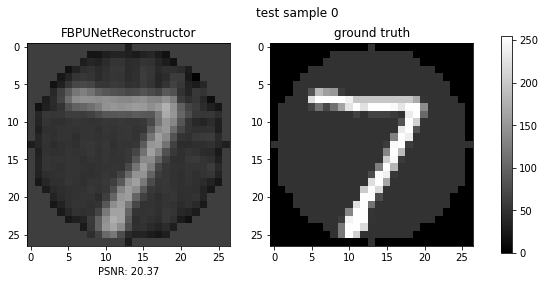

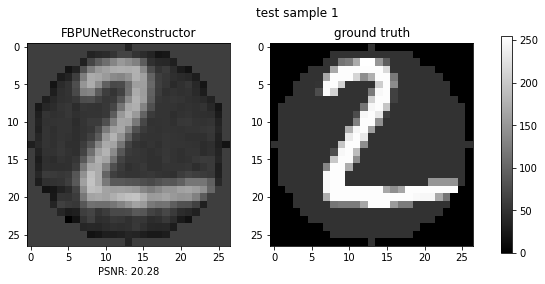

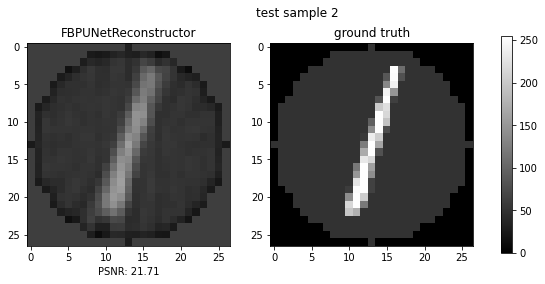

In [7]:
for i in range(3):
    _, ax = plot_images([recos[i].T, gts[i].T],
                        fig_size=(10, 4))
    ax[0].set_xlabel('PSNR: {:.2f}'.format(psnrs[i]))
    ax[0].set_title('FBPUNetReconstructor')
    ax[1].set_title('ground truth')
    ax[0].figure.suptitle('test sample {:d}'.format(i))